In [37]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import random
import ast
import music21
import textract
import pathlib
from collections import defaultdict
from collections import Counter
import networkx as nx
import seaborn as sns
random.seed(10)

In [38]:
data_train = pd.read_csv('./train.csv')
data_train['beat_pitch'] = data_train['beat_pitch'].apply(ast.literal_eval)
data_train['pitches'] = data_train['pitches'].apply(ast.literal_eval)

In [39]:
high=0
low=0
for i in range(len(data_train['pitches'])):
    piece=data_train['pitches'][i]  
    piece=np.array(sum(piece,[]))    
    if high<np.max(piece):
        high=np.max(piece)
    if low>np.min(piece):
        low=np.min(piece)
print(high)
print(low)

89
0


In [40]:
def format_transition_1(piece):
    # Transfer the beat_pitch format to 12-position 1-12 scale format
    # arg: 1.piece: one piece of music in beat_pitch format
    # return: 1.re: the transfer format of the piece, re is in shape of number_of_bars * 12
    re=np.zeros((len(piece),12))
    for i in range(len(piece)):
        bar=piece[i]
        for j in range(len(bar)):            
            re[i][bar[j][0]-1]=(bar[j][1]-low)/(high-low)
    return re

In [41]:
class LSTM(nn.Module):
    def __init__(self, INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional):
        super(LSTM, self).__init__()

        self.LSTM = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            bias=True,
            batch_first=True,
            dropout=0,
            bidirectional=Bidirectional,
            proj_size=0
        )

        self.out = nn.Linear(HIDDEN_SIZE*SEQ_LEN,OUTPUT_SIZE)

    def forward(self, x, hidden_state):
        output, h_state = self.LSTM(x,hidden_state)
        outs = []  #for different batch
        for time in range(output.size(0)):
            outs.append(self.out(output[time, :, :].reshape(-1)))            
        return torch.stack(outs, dim=1), h_state

# Prediction for the Beginning

In [53]:
INPUT_SIZE=12*2    # number of notes for one prediction
HIDDEN_SIZE=15   # size of the hidden units
NUM_LAYERS=1
NUM_DIRECTION=1
Bidirectional=False
SEQ_LEN=4    # number of time steps for one prediction
BATCH_SIZE=20
OUTPUT_SIZE=12*2    # number of notes for predicted result
lr=0.002
if(NUM_DIRECTION==1):
    Bidirectional = False
else:
    Bidirectional = True
ITERATION=4
EPOCH=15

model1:
 LSTM(
  (LSTM): LSTM(24, 15, batch_first=True)
  (out): Linear(in_features=60, out_features=24, bias=True)
)
1
loss: tensor(0.5120, grad_fn=<MseLossBackward>)
2
loss: tensor(0.4840, grad_fn=<MseLossBackward>)
3
loss: tensor(0.3572, grad_fn=<MseLossBackward>)
4
loss: tensor(0.3675, grad_fn=<MseLossBackward>)
1
loss: tensor(0.3317, grad_fn=<MseLossBackward>)
2
loss: tensor(0.3630, grad_fn=<MseLossBackward>)
3
loss: tensor(0.3086, grad_fn=<MseLossBackward>)
4
loss: tensor(0.3073, grad_fn=<MseLossBackward>)
1
loss: tensor(0.3054, grad_fn=<MseLossBackward>)
2
loss: tensor(0.2769, grad_fn=<MseLossBackward>)
3
loss: tensor(0.2881, grad_fn=<MseLossBackward>)
4
loss: tensor(0.2663, grad_fn=<MseLossBackward>)
1
loss: tensor(0.2371, grad_fn=<MseLossBackward>)
2
loss: tensor(0.2208, grad_fn=<MseLossBackward>)
3
loss: tensor(0.2283, grad_fn=<MseLossBackward>)
4
loss: tensor(0.2256, grad_fn=<MseLossBackward>)
1
loss: tensor(0.2165, grad_fn=<MseLossBackward>)
2
loss: tensor(0.2151, grad_fn=<

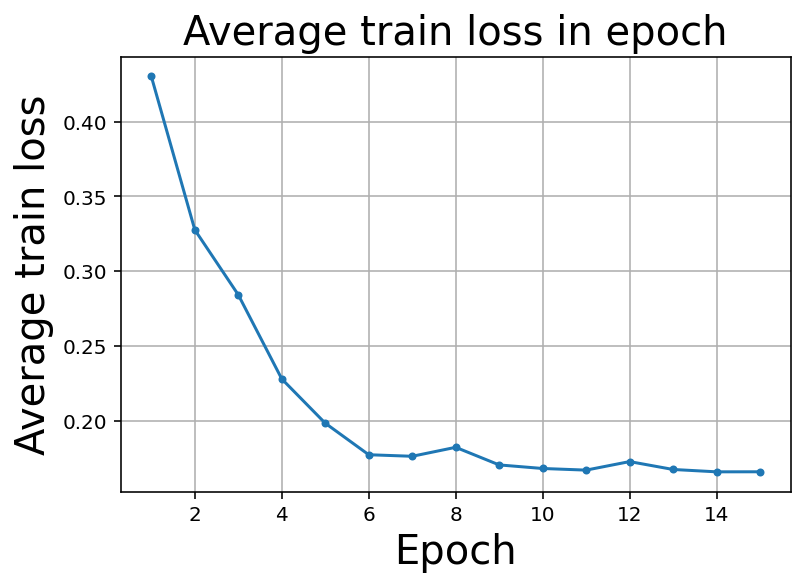

In [54]:
def train():
    model1 = LSTM(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional)
    print('model1:\n', model1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model1.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    h_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))  #initialize hidden_state
    c_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))
    hidden_state=(h_0,c_0)   
    
    aver_loss_epoch=[]
    for ep in range(1,EPOCH+1):
        loss_epoch=[]  
        counter=0
        for iter in range(1,ITERATION+1):
            x =[]
            y=[]    
            i=0                
            while(i!=BATCH_SIZE):                
                j=0                     
                x_x=[]                
                while(j!=SEQ_LEN):                
                    try:
                        piece_now=format_transition_1(data_train['beat_pitch'][counter])                        
                        x_x.append(np.append(piece_now[0],piece_now[1]))                        
                        j=j+1  
                        counter=counter+1                        
                    except:
                        counter=counter+1
                        continue                              
                i=i+1
                x.append(x_x)
                y_index=random.randint(0,362)
                y_piece=format_transition_1(data_train['beat_pitch'][y_index])
                while(True):
                    if len(y_piece)>=2:
                        break
                    else:
                        y_index=random.randint(0,362)
                        y_piece=format_transition_1(data_train['beat_pitch'][y_index])
                y.append(np.append(y_piece[0],y_piece[1]))
                    
                             
            x=np.array(x)               
            x = x.reshape([BATCH_SIZE, SEQ_LEN, INPUT_SIZE])
            x=torch.tensor(x,dtype=torch.float32)
            y=np.array(y)        
            y=y.reshape([INPUT_SIZE,BATCH_SIZE])
            y=torch.tensor(y,dtype=torch.float32)
            output, hidden_state = model1(x, hidden_state)           
            h_0, c_0 = hidden_state
            h_0.detach_()
            c_0.detach_()
            hidden_state = (h_0, c_0)
            print(iter)           
            model1.zero_grad()
            loss=criterion(output, y)
            loss_epoch.append(loss.item())
            print("loss: "+str(loss))
            torch.autograd.set_detect_anomaly(True)
            #with torch.autograd.detect_anomaly():
                #loss.backward()
            loss.backward()
            nn.utils.clip_grad_norm_(model1.parameters(),max_norm=2)
            optimizer.step()
        aver_loss_epoch.append(sum(loss_epoch)/len(loss_epoch))
        scheduler.step()
    plot_EPOCH_LOSS(aver_loss_epoch)
    return model1,hidden_state
        
def plot_EPOCH_LOSS(loss_list):
    plt.cla()
    x1 = range(1, len(loss_list)+1)
    y1 = loss_list
    plt.title('Average train loss in epoch', fontsize=20)
    plt.plot(x1, y1, '.-')
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Average train loss', fontsize=20)
    plt.grid()    

model1,hidden_state1=train()

## Prediction for the Endding

In [75]:
INPUT_SIZE=12    # number of notes for one prediction
HIDDEN_SIZE=15   # size of the hidden units
NUM_LAYERS=1
NUM_DIRECTION=1
Bidirectional=False
SEQ_LEN=2    # number of time steps for one prediction
BATCH_SIZE=20
OUTPUT_SIZE=12*2    # number of notes for predicted result
lr=0.002
if(NUM_DIRECTION==1):
    Bidirectional = False
else:
    Bidirectional = True
ITERATION=16
EPOCH=10

model2:
 LSTM(
  (LSTM): LSTM(12, 15, batch_first=True)
  (out): Linear(in_features=30, out_features=24, bias=True)
)
1
loss: tensor(0.3971, grad_fn=<MseLossBackward>)
2
loss: tensor(0.4104, grad_fn=<MseLossBackward>)
3
loss: tensor(0.3864, grad_fn=<MseLossBackward>)
4
loss: tensor(0.3793, grad_fn=<MseLossBackward>)
5
loss: tensor(0.3726, grad_fn=<MseLossBackward>)
6
loss: tensor(0.3854, grad_fn=<MseLossBackward>)
7
loss: tensor(0.3525, grad_fn=<MseLossBackward>)
8
loss: tensor(0.3392, grad_fn=<MseLossBackward>)
9
loss: tensor(0.3413, grad_fn=<MseLossBackward>)
10
loss: tensor(0.3315, grad_fn=<MseLossBackward>)
11
loss: tensor(0.2895, grad_fn=<MseLossBackward>)
12
loss: tensor(0.3426, grad_fn=<MseLossBackward>)
13
loss: tensor(0.3283, grad_fn=<MseLossBackward>)
14
loss: tensor(0.2669, grad_fn=<MseLossBackward>)
15
loss: tensor(0.2612, grad_fn=<MseLossBackward>)
16
loss: tensor(0.2900, grad_fn=<MseLossBackward>)
1
loss: tensor(0.2434, grad_fn=<MseLossBackward>)
2
loss: tensor(0.2394, gr

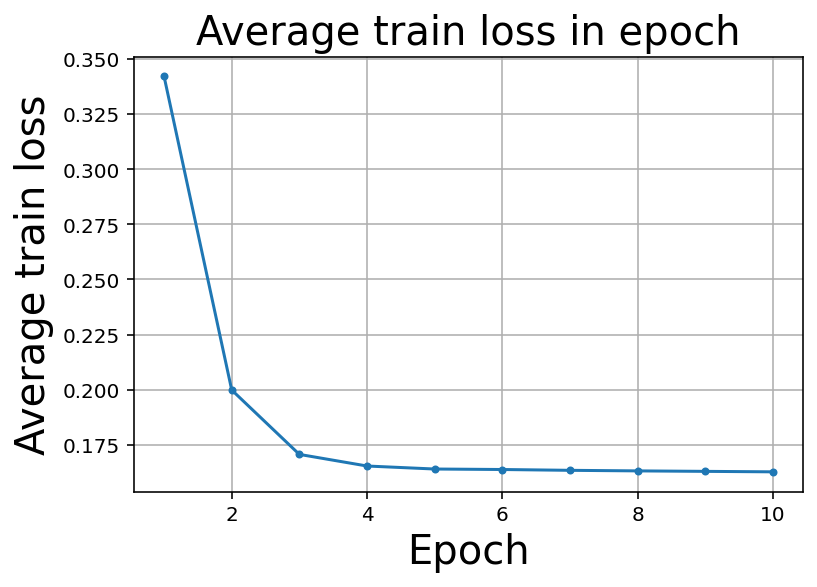

In [76]:
def train():
    model2 = LSTM(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional)
    print('model2:\n', model2)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model2.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    h_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))  #initialize hidden_state
    c_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))
    hidden_state=(h_0,c_0)   
    
    aver_loss_epoch=[]
    for ep in range(1,EPOCH+1):
        loss_epoch=[] 
        counter=0
        for iter in range(1,ITERATION+1):
            x =[]
            y=[]    
            i=0                
            while(i!=BATCH_SIZE):                
                j=0                     
                x_x=[]   
                piece_now=format_transition_1(data_train['beat_pitch'][counter])
                while(j!=SEQ_LEN):                
                    try:                                                
                        x_x.append(piece_now[0])
                        x_x.append(piece_now[1])
                        j=j+2  
                        counter=counter+1
                    except:
                        counter=counter+1
                        continue                              
                i=i+1
                x.append(x_x)                
                y.append(np.append(piece_now[-2],piece_now[-1]))
                    
                             
            x=np.array(x)               
            x = x.reshape([BATCH_SIZE, SEQ_LEN, INPUT_SIZE])
            x=torch.tensor(x,dtype=torch.float32)
            y=np.array(y)        
            y=y.reshape([OUTPUT_SIZE,BATCH_SIZE])
            y=torch.tensor(y,dtype=torch.float32)
            output, hidden_state = model2(x, hidden_state)           
            h_0, c_0 = hidden_state
            h_0.detach_()
            c_0.detach_()
            hidden_state = (h_0, c_0)
            print(iter)           
            model2.zero_grad()
            loss=criterion(output, y)
            loss_epoch.append(loss.item())
            print("loss: "+str(loss))
            torch.autograd.set_detect_anomaly(True)
            #with torch.autograd.detect_anomaly():
                #loss.backward()
            loss.backward()
            nn.utils.clip_grad_norm_(model2.parameters(),max_norm=2)
            optimizer.step()
        aver_loss_epoch.append(sum(loss_epoch)/len(loss_epoch))
        scheduler.step()
    plot_EPOCH_LOSS(aver_loss_epoch)
    return model2,hidden_state
        
def plot_EPOCH_LOSS(loss_list):
    plt.cla()
    x1 = range(1, len(loss_list)+1)
    y1 = loss_list
    plt.title('Average train loss in epoch', fontsize=20)
    plt.plot(x1, y1, '.-')
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Average train loss', fontsize=20)
    plt.grid()    

model2,hidden_state2=train()

## Prediction for the middle

In [81]:
INPUT_SIZE=12    # number of notes for one prediction
HIDDEN_SIZE=15   # size of the hidden units
NUM_LAYERS=1
NUM_DIRECTION=1
Bidirectional=False
SEQ_LEN=4    # number of time steps for one prediction
BATCH_SIZE=20
OUTPUT_SIZE=12*4    # number of notes for predicted result
lr=0.002
if(NUM_DIRECTION==1):
    Bidirectional = False
else:
    Bidirectional = True
ITERATION=16
EPOCH=10

model3:
 LSTM(
  (LSTM): LSTM(12, 15, batch_first=True)
  (out): Linear(in_features=60, out_features=48, bias=True)
)
1
loss: tensor(0.4383, grad_fn=<MseLossBackward>)
2
loss: tensor(0.4741, grad_fn=<MseLossBackward>)
3
loss: tensor(0.4117, grad_fn=<MseLossBackward>)
4
loss: tensor(0.3946, grad_fn=<MseLossBackward>)
5
loss: tensor(0.3732, grad_fn=<MseLossBackward>)
6
loss: tensor(0.3683, grad_fn=<MseLossBackward>)
7
loss: tensor(0.3306, grad_fn=<MseLossBackward>)
8
loss: tensor(0.2967, grad_fn=<MseLossBackward>)
9
loss: tensor(0.3072, grad_fn=<MseLossBackward>)
10
loss: tensor(0.2853, grad_fn=<MseLossBackward>)
11
loss: tensor(0.2527, grad_fn=<MseLossBackward>)
12
loss: tensor(0.2280, grad_fn=<MseLossBackward>)
13
loss: tensor(0.2400, grad_fn=<MseLossBackward>)
14
loss: tensor(0.2183, grad_fn=<MseLossBackward>)
15
loss: tensor(0.2185, grad_fn=<MseLossBackward>)
16
loss: tensor(0.2075, grad_fn=<MseLossBackward>)
1
loss: tensor(0.1927, grad_fn=<MseLossBackward>)
2
loss: tensor(0.1812, gr

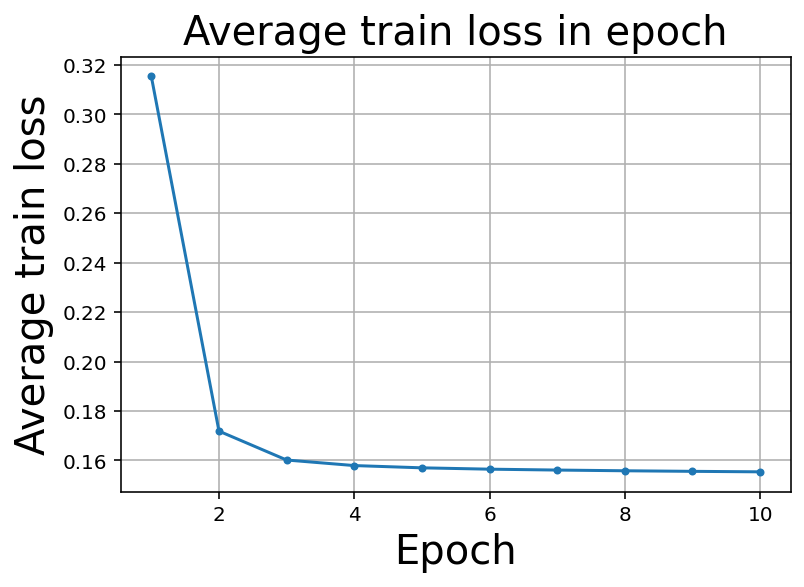

In [82]:
def train():
    model3 = LSTM(INPUT_SIZE,HIDDEN_SIZE,NUM_LAYERS,Bidirectional)
    print('model3:\n', model3)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model3.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    h_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))  #initialize hidden_state
    c_0 = torch.normal(1, 0.2, size=(NUM_LAYERS*NUM_DIRECTION,BATCH_SIZE, HIDDEN_SIZE))
    hidden_state=(h_0,c_0)   
    
    aver_loss_epoch=[]
    for ep in range(1,EPOCH+1):
        loss_epoch=[] 
        counter=0
        for iter in range(1,ITERATION+1):
            x =[]
            y=[]    
            i=0                
            while(i!=BATCH_SIZE):                
                j=0                                          
                piece_now=[]
                while(j!=SEQ_LEN):  
                    x_x=[]
                    piece_now=format_transition_1(data_train['beat_pitch'][counter])
                    try:                                                
                        x_x.append(piece_now[0])
                        x_x.append(piece_now[1])
                        x_x.append(piece_now[-2])
                        x_x.append(piece_now[-1])
                        test=piece_now[3] # to test if the piece have more than 3 bars
                        j=j+4  
                        counter=counter+1
                    except:
                        counter=counter+1
                        continue                  
                i=i+1                
                x.append(x_x)                  
                piece1=np.append(piece_now[2],piece_now[3])
                piece2=np.append(piece_now[-4],piece_now[-3])
                y.append(np.append(piece1,piece2))
                    
                             
            x=np.array(x)               
            x = x.reshape([BATCH_SIZE, SEQ_LEN, INPUT_SIZE])
            x=torch.tensor(x,dtype=torch.float32)
            y=np.array(y)        
            y=y.reshape([OUTPUT_SIZE,BATCH_SIZE])
            y=torch.tensor(y,dtype=torch.float32)
            output, hidden_state = model3(x, hidden_state)           
            h_0, c_0 = hidden_state
            h_0.detach_()
            c_0.detach_()
            hidden_state = (h_0, c_0)
            print(iter)           
            model3.zero_grad()
            loss=criterion(output, y)
            loss_epoch.append(loss.item())
            print("loss: "+str(loss))
            torch.autograd.set_detect_anomaly(True)
            #with torch.autograd.detect_anomaly():
                #loss.backward()
            loss.backward()
            nn.utils.clip_grad_norm_(model3.parameters(),max_norm=2)
            optimizer.step()
        aver_loss_epoch.append(sum(loss_epoch)/len(loss_epoch))
        scheduler.step()
    plot_EPOCH_LOSS(aver_loss_epoch)
    return model3,hidden_state
        
def plot_EPOCH_LOSS(loss_list):
    plt.cla()
    x1 = range(1, len(loss_list)+1)
    y1 = loss_list
    plt.title('Average train loss in epoch', fontsize=20)
    plt.plot(x1, y1, '.-')
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Average train loss', fontsize=20)
    plt.grid()    

model3,hidden_state3=train()

# Prediction

In [69]:
data_test = pd.read_csv('./test.csv')
data_test['beat_pitch'] = data_test['beat_pitch'].apply(ast.literal_eval)
data_test['pitches'] = data_test['pitches'].apply(ast.literal_eval)

In [70]:
data1=[]
for i in range(20):
    # generate the beginning
    beginning_data=[]
    j=0
    while(j!=4):
        index=random.randint(0,len(data_test)-1) 
        piece_now=format_transition_1(data_test['beat_pitch'][index]) 
        try:                                   
            beginning_data.append(np.append(piece_now[0],piece_now[1])) 
            j=j+1
        except:
            continue
    beginning_data=np.array(beginning_data)               
    beginning_data = beginning_data.reshape([4, 12*2])
    data1.append(beginning_data)
    
data1=np.array(data1)
data1 = data1.reshape([20,4, 12*2])
data1=torch.tensor(data1,dtype=torch.float32)

predict_beginning=[]
with torch.no_grad():        
    model1.eval()
    pred,new_hidden_state = model1(data1, hidden_state1)    
    pred=np.array(pred)    
    pred=pred.T    
    predict_beginning=pred.tolist()


(20, 24)


In [78]:
data2=[]
for i in range(20):
    # generate the endding
    endding_data=[]
    p1=predict_beginning[i][0:12]
    p2=predict_beginning[i][12:24]
    endding_data.append(p1)
    endding_data.append(p2)    
    data2.append(endding_data)
    
data2=np.array(data2)
data2 = data2.reshape([20,2,12])
data2=torch.tensor(data2,dtype=torch.float32)

predict_endding=[]
with torch.no_grad():        
    model2.eval()
    pred,new_hidden_state = model2(data2, hidden_state2)    
    pred=np.array(pred)    
    pred=pred.T    
    predict_endding=pred.tolist()   

(20, 24)


In [83]:
data3=[]
for i in range(20):
    # generate the middle
    middle_data=[]
    p1=predict_beginning[i][0:12]
    p2=predict_beginning[i][12:24]
    p3=predict_endding[i][0:12]
    p4=predict_endding[i][12:24]
    middle_data.append(p1)
    middle_data.append(p2)    
    middle_data.append(p3)
    middle_data.append(p4)
    data3.append(middle_data)
    
data3=np.array(data3)
data3 = data3.reshape([20,4,12])
data3=torch.tensor(data3,dtype=torch.float32)

predict_middle=[]
with torch.no_grad():        
    model3.eval()
    pred,new_hidden_state = model3(data3, hidden_state3)    
    pred=np.array(pred)    
    pred=pred.T    
    predict_middle=pred.tolist()
    print(np.shape(predict_middle))

(20, 48)


In [91]:
# combine three parts
predict_result=[]
for i in range(20):    
    piece=predict_beginning[i]+predict_middle[i]+predict_endding[i]
    predict_result.append(piece)
predict_result=np.array(predict_result)
predict_result=np.floor((predict_result)*(high-low)+low)
print(predict_result)

[[52. 37. 42. ... 42. 35. 37.]
 [43. 39. 35. ... 42. 33. 34.]
 [45. 40. 41. ... 40. 33. 33.]
 ...
 [53. 39. 40. ... 43. 36. 35.]
 [49. 41. 37. ... 42. 35. 34.]
 [51. 39. 40. ... 41. 35. 35.]]
